# Objects classification

#### Neural Network for Suggestive CAD

--------------------------------------------------------------------------------------------------------------------------------

    Import packages

In [1]:
import numpy as np
import collections
#from tensorflow.python.framework import dtypes

from os import listdir
import os
from os.path import isfile, join
import numpy as np
import cv2
import scipy as misc

import matplotlib.pylab as plt
%matplotlib inline

from __future__ import division
from __future__ import print_function

import argparse
import sys

import glob
#import param
import time

#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
import IPython.display as display

import tensorflow as tf

#import pydotplus as pydot
#import graphviz



# KERAS IMPORTS
import keras
from keras import applications
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization 
from keras.layers.advanced_activations import LeakyReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import History 
from keras.models import model_from_json

#SKLEARN
from sklearn.metrics import classification_report

C:\Users\TempUser\Anaconda3\envs\CPU_tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
###From https://gist.github.com/ambodi/408301bc5bc07bc5afa8748513ab9477#file-dataset-py-L74

In [4]:
###Data from  https://www.kaggle.com/c/dogs-vs-cats/data

## Saving raw data to npy

#### Load data

In [35]:
#path to directory
path_train = 'data/_train/'
path_test = 'data/_val/'
path_val = 'data/_val/'

img_size= 200

#get folder names
def directory_scan(path):
    dirlist = [ item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item)) ]
    return dirlist

#build labels and image arrays, resize image to 500*500
def read_images_in_folder(dirlist, path):
    images=[]
    labels = []
    count = 0
    for i in range(len(dirlist)):
        image_stack = []
        for img in glob.glob(path+dirlist[i]+'/*jpg'):
            count=count+1
            labels.append(dirlist[i])
            IMG = cv2.imread(img)
            #RGB to grey scale
            #IMG_2= cv2.cvtColor( IMG, cv2.COLOR_RGB2GRAY )
            #resize to 100*100
            im_resize = cv2.resize(IMG, (img_size, img_size), 3)
            images.append(im_resize)
        #np_images = np.array(image_stack)
        
    return images, labels, count

In [36]:
dirlist_val = directory_scan(path_val)
dirlist_train = directory_scan(path_train)

In [53]:
np.save('labels/labels_chair',dirlist_val)

In [39]:
if __name__ == '__main__':
    dirlist_train = directory_scan(path_train)
    images_train,labels_train,count_train = read_images_in_folder(dirlist_train, path_train)

if __name__ == '__main__':
    dirlist_val = directory_scan(path_val)
    images_val,labels_val,count_val= read_images_in_folder(dirlist_val, path_val)

#np.save('npy-color/images_val_shapenet',images_val)
#np.save('npy-color/labels_val_shapenet',labels_val)

#save to file
#np.save('npy-color/images_train_shapenet',images_train)
#np.save('npy-color/labels_train_shapenet',labels_train)
#np.save('npy-color/images_test_shapenet',images_test)
#np.save('npy-color/labels_test_shapenet',labels_test)

print('There are '+ str(count_train) +' training images')
print('There are '+ str(count_val) +' validation images')

nb_img_train = count_train
#nb_img_test = count_test
nb_img_val = count_val

There are 6000 training images
There are 2000 validation images


In [40]:
train_labels = labels_train
train_images = images_train
val_images = images_val
val_labels = labels_val

chair_0007


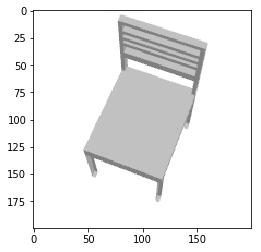

In [13]:
index = 200
print(train_labels[index])
plt.imshow(train_images[index])

In [14]:
#prepare and reshape testing/training sets
val_img = np.array(val_images).astype('float32')/255
train_img = np.array(train_images).astype('float32')/255

#### One Hot Encoding of Labels

In [15]:
#LABEL ONE HOT ENCODING
#Training
k=0
for i in range(len(dirlist_train)):
    for j in range(len(train_labels)):
        if(train_labels[j]==dirlist_train[i]):
            train_labels[j]=k
    k=k+1
    
#Validation
g=0
for l in range(len(dirlist_val)):
    for h in range(len(val_labels)):
        if(val_labels[h]==dirlist_val[l]):
            val_labels[h]=g
    g=g+1

In [16]:
train_lab= to_categorical(train_labels)
val_lab = to_categorical(val_labels)

In [17]:
def Plot_accuracy(train_acc, val_acc, Title):
    x = [i for i in range(0, len(train_acc))]
    y= train_acc
    plt.plot(x,y)
    
    x = [i for i in range(0, len(val_acc))]
    y= val_acc
    plt.plot(x,y)
    
    plt.ylabel('Accuracy')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=1)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.title(Title)
    plt.show()
    
def Plot_Loss(train_loss, val_loss, Title):
    x = [i for i in range(0, len(val_loss))]
    y= train_loss
    plt.plot(x,y)

    x = [i for i in range(0, len(val_loss))]
    y= val_loss
    plt.plot(x,y)
    
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(ymax=2)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.grid(True)
    plt.title(Title)
    plt.show()

--------------------------------------------------------------------------------------------------------------------------------

## VGG

https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/

    Import VGG pretrained network

In [18]:
conv_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [19]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

    Preprocess dataset with VGG model

In [20]:
#gets feature maps for dataset based on inital VGG model
#    >>from training set to feature map
start = time.time()

train_features = conv_base.predict(train_img, verbose=1)
#train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

6000/6000 [==============================] - 2064s 344ms/step
Execution time = 34 min 24.1362042427063 sec


In [21]:
train_features.shape

(6000, 6, 6, 512)

In [22]:
#reshape feature maps to match output of VGG model with input of additional layers
train_features_reshaped = np.reshape(train_features, (len(train_img), 6 * 6 * 512))

In [23]:
#Save feature maps to file
np.save('feature_maps/train_features', train_features_reshaped)

In [24]:
#loads feature map from file
train_features_ = np.load('feature_maps/train_features.npy')

In [25]:
train_features_.shape

(6000, 18432)

In [26]:
#gets feature maps for dataset based on inital VGG model
#    >>from training set to feature map
start = time.time()

val_features = conv_base.predict(val_img, verbose=1)
#train_features = np.reshape(train_features, (len(train_img), 3 * 3 * 512))

stop = time.time()
print("Execution time = " + str(int(((stop-start)-(stop-start)%60)/60)) +" min "+str((stop-start)%60)+" sec")

2000/2000 [==============================] - 681s 341ms/step
Execution time = 11 min 21.302665948867798 sec


In [27]:
val_features = np.reshape(val_features, (len(val_img), 6 * 6 * 512))

In [28]:
#Save feature maps to file
np.save('feature_maps/val_features', val_features)

In [29]:
#loads feature map from file
val_features_ = np.load('feature_maps/val_features.npy')

In [34]:
dirlist_train

['chair_0001',
 'chair_0002',
 'chair_0003',
 'chair_0004',
 'chair_0005',
 'chair_0006',
 'chair_0007',
 'chair_0008',
 'chair_0009',
 'chair_0010',
 'chair_0011',
 'chair_0012',
 'chair_0013',
 'chair_0014',
 'chair_0015',
 'chair_0016',
 'chair_0017',
 'chair_0018',
 'chair_0019',
 'chair_0020',
 'chair_0021',
 'chair_0022',
 'chair_0023',
 'chair_0024',
 'chair_0025',
 'chair_0026',
 'chair_0027',
 'chair_0028',
 'chair_0029',
 'chair_0030',
 'chair_0031',
 'chair_0032',
 'chair_0033',
 'chair_0034',
 'chair_0035',
 'chair_0036',
 'chair_0037',
 'chair_0038',
 'chair_0039',
 'chair_0040',
 'chair_0041',
 'chair_0042',
 'chair_0043',
 'chair_0044',
 'chair_0045',
 'chair_0046',
 'chair_0047',
 'chair_0048',
 'chair_0049',
 'chair_0050',
 'chair_0051',
 'chair_0052',
 'chair_0053',
 'chair_0054',
 'chair_0055',
 'chair_0056',
 'chair_0057',
 'chair_0058',
 'chair_0059',
 'chair_0060',
 'chair_0061',
 'chair_0062',
 'chair_0063',
 'chair_0064',
 'chair_0065',
 'chair_0066',
 'chair_00

    Additional network

In [42]:
model = models.Sequential()
model.add(layers.Dense(600, activation='relu', input_dim=6 * 6 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(600, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(len(dirlist_train), activation='softmax'))

In [43]:
history= History()

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
 
training = model.fit(train_features_,
                    train_lab,
                    epochs=90,
                    batch_size=100,
                    validation_data=(val_features,val_lab), callbacks=[history])

Train on 6000 samples, validate on 2000 samples
Epoch 1/90
6000/6000 [==============================] - 14s 2ms/step - loss: 5.3825 - acc: 0.0057 - val_loss: 5.2937 - val_acc: 0.0060
Epoch 2/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.3040 - acc: 0.0042 - val_loss: 5.2832 - val_acc: 0.0090
Epoch 3/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.2878 - acc: 0.0090 - val_loss: 5.2522 - val_acc: 0.0215
Epoch 4/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.2408 - acc: 0.0077 - val_loss: 5.1788 - val_acc: 0.0195
Epoch 5/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.1793 - acc: 0.0112 - val_loss: 5.0984 - val_acc: 0.0230
Epoch 6/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.1142 - acc: 0.0142 - val_loss: 4.9995 - val_acc: 0.0265
Epoch 7/90
6000/6000 [==============================] - 13s 2ms/step - loss: 5.0280 - acc: 0.0157 - val_loss: 4.9156 - val_acc: 0.0345
Epoch 8

Epoch 61/90
6000/6000 [==============================] - 13s 2ms/step - loss: 2.6363 - acc: 0.2688 - val_loss: 2.2840 - val_acc: 0.4950
Epoch 62/90
6000/6000 [==============================] - 13s 2ms/step - loss: 2.6109 - acc: 0.2800 - val_loss: 2.2557 - val_acc: 0.5125
Epoch 63/90
6000/6000 [==============================] - 13s 2ms/step - loss: 2.5748 - acc: 0.2837 - val_loss: 2.2025 - val_acc: 0.5165
Epoch 64/90
6000/6000 [==============================] - 13s 2ms/step - loss: 2.6233 - acc: 0.2758 - val_loss: 2.2202 - val_acc: 0.5210
Epoch 65/90
6000/6000 [==============================] - 13s 2ms/step - loss: 2.5804 - acc: 0.2740 - val_loss: 2.1897 - val_acc: 0.5215
Epoch 66/90
6000/6000 [==============================] - 13s 2ms/step - loss: 2.5673 - acc: 0.2833 - val_loss: 2.1856 - val_acc: 0.5045
Epoch 67/90
6000/6000 [==============================] - 13s 2ms/step - loss: 2.5531 - acc: 0.2868 - val_loss: 2.2019 - val_acc: 0.5115
Epoch 68/90
6000/6000 [=========================

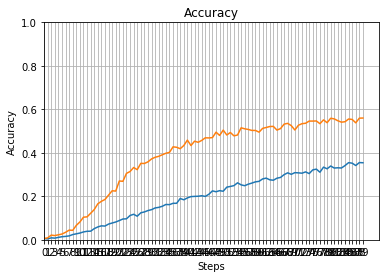

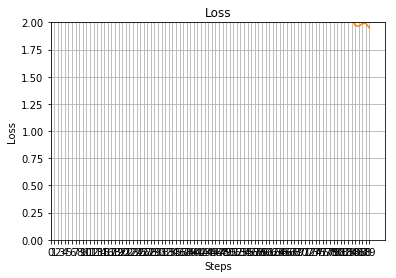

In [44]:
Plot_accuracy(history.history['acc'], history.history['val_acc'],"Accuracy")

Plot_Loss(history.history['loss'],history.history['val_loss'], "Loss")

    Test

In [45]:
predictions = model.predict(val_features)

#one hot encoding
for i in range(len(predictions)):
    length = len(predictions[i])
    index = np.argmax(predictions[i])
    predictions[i][index] = 1
    for j in range(length):
        if(j != index):
            predictions[i][j] = 0

In [46]:
print(classification_report(val_lab, predictions, target_names = dirlist_val))

             precision    recall  f1-score   support

 chair_0001       0.75      0.30      0.43        10
 chair_0002       0.75      0.30      0.43        10
 chair_0003       0.50      0.40      0.44        10
 chair_0004       0.43      0.30      0.35        10
 chair_0005       0.08      0.10      0.09        10
 chair_0006       0.78      0.70      0.74        10
 chair_0007       0.14      0.10      0.12        10
 chair_0008       1.00      0.70      0.82        10
 chair_0009       0.20      0.10      0.13        10
 chair_0010       0.70      0.70      0.70        10
 chair_0011       0.83      0.50      0.62        10
 chair_0012       0.00      0.00      0.00        10
 chair_0013       0.62      0.80      0.70        10
 chair_0014       0.71      1.00      0.83        10
 chair_0015       0.50      0.30      0.37        10
 chair_0016       0.60      0.90      0.72        10
 chair_0017       0.33      0.10      0.15        10
 chair_0018       0.67      0.60      0.63   

C:\Users\TempUser\Anaconda3\envs\CPU_tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Save Model to File

In [50]:
# serialize model to JSON
model_json = model.to_json()
with open("model/model_chair.json", "w") as json_file:
    json_file.write(model_json)

In [51]:
# serialize weights to HDF5
model.save_weights("model/model_chair.h5")
print("Saved model to disk")

Saved model to disk


--------------------------------------------------------------------------------------------------------------------------------

## Predict

#### Load VGG16

In [49]:
conv_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(200, 200,3))

#### Load Model & Labels

In [52]:
# load json and create model
json_file = open('model/model_chair.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model/model_chair.h5")
print("Loaded model from disk")

Loaded model from disk


In [55]:
labels = np.load('labels/labels_chair.npy')

#### Predict

In [106]:
def plot_predict(predictions, actual_class):
    fig = plt.figure(figsize=(15, 8))
    fig.patch.set_facecolor('white')

    ax1 = fig.add_subplot(2, 2, 1)
    plt.tick_params(
    bottom='off',      
    top='off',
    left='off',
    labelleft = 'off',
    labelbottom = 'off')   
    plt.imshow(test_img)
    plt.title('3D Model image')

    #Plot Day Count
    fig.add_subplot(2, 2, 2)
    barlist = plt.bar(np.arange(len(predictions[0])),predictions[0])
    if(labels[np.argmax(predictions[0])] != actual_class):
        barlist[np.argmax(predictions[0])].set_color('r')
    elif(labels[np.argmax(predictions[0])] == actual_class):
        barlist[np.argmax(predictions[0])].set_color('g')
    plt.ylabel('Prediction Confidence (in percent)')
    plt.xlabel('Classes')
    plt.xticks(range(len(labels)), labels, rotation=70, fontsize=4)
    plt.grid(linestyle='dotted', linewidth=.8)
    plt.yticks(np.linspace(0, 1.0, num=11), fontsize=10)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    #plt.grid(True)
    #plt.title(Days[index] + " @ " +Stores[store_id]['name'])
    plt.tight_layout()

chair_0044
Prediction Confidence : 7.7490463852882385%


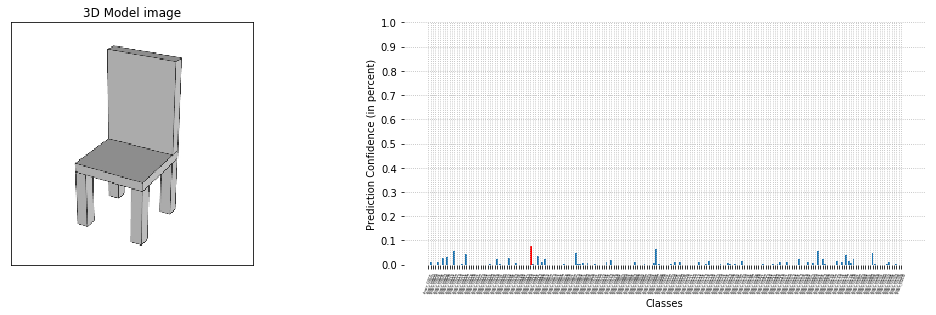

In [107]:
img_size = 200

IMG = cv2.imread('test_img/v2.jpg')
test_img = cv2.resize(IMG, (img_size, img_size), 3)
test_img = test_img.astype(np.float32)/255

predictions = model.predict(np.reshape(conv_base.predict(test_img.reshape([1,img_size,img_size,3])), (1, 6 * 6 * 512)))

plot_predict(predictions, 'chair')


print(labels[np.argmax(predictions[0])])
print("Prediction Confidence : "+ str(np.max(predictions[0])*100)+ "%")

#### Find Best Match

chair_0044


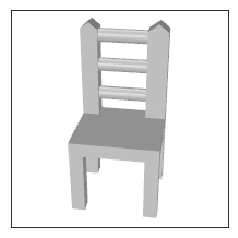

In [103]:
print(labels[np.argmax(predictions[0])])
path_to_file = 'data/_train' + '/'+ labels[np.argmax(predictions[0])] + '/' + labels[np.argmax(predictions[0])] + '_view24.jpg'
IMG = cv2.imread(path_to_file)
plt.tick_params(
bottom='off',      
top='off',
left='off',
labelleft = 'off',
labelbottom = 'off')   
plt.imshow(IMG)

#### Ordered list of best matches

Generate list of sorted matches, and their image. Print histogram of to 10 sorted prediciton values (and associated image if possible)

In [72]:
sorted_matches = sorted(range(len(predictions[0])), key=lambda k: predictions[0][k], reverse=True)
for item in labels[sorted_matches][:10]:
    print(item)

chair_0044
chair_0097
chair_0012
chair_0165
chair_0188
chair_0063
chair_0017
chair_0177
chair_0047
chair_0009


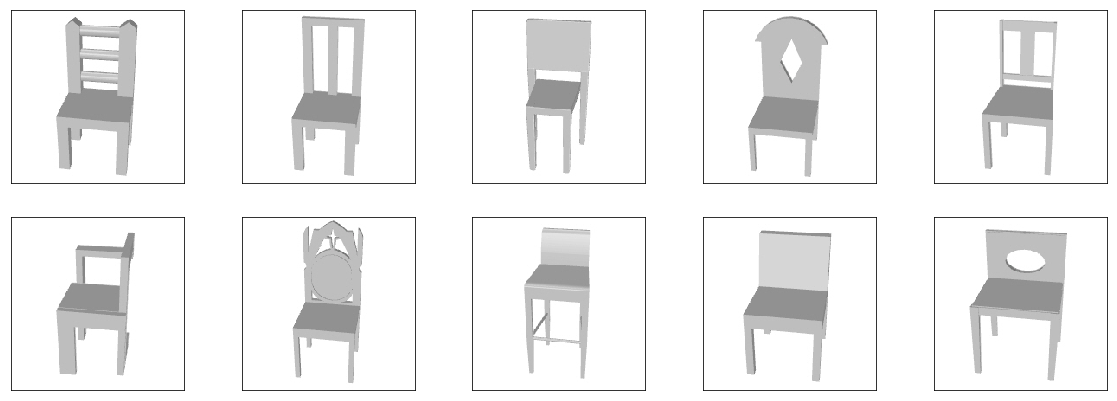

In [102]:
fig=plt.figure(figsize=(20, 7))
columns = 5
rows = 2
for i in range(1, columns*rows+1):
    img = cv2.imread('data/_train' + '/'+ labels[sorted_matches][:10][i-1] + '/' + labels[sorted_matches][:10][i-1] 
                     + '_view24.jpg')
    fig.add_subplot(rows, columns, i)
    plt.tick_params(
    bottom='off',      
    top='off',
    left='off',
    labelleft = 'off',
    labelbottom = 'off')   
    plt.imshow(img)
plt.show()

#### Ordered list of worst matches

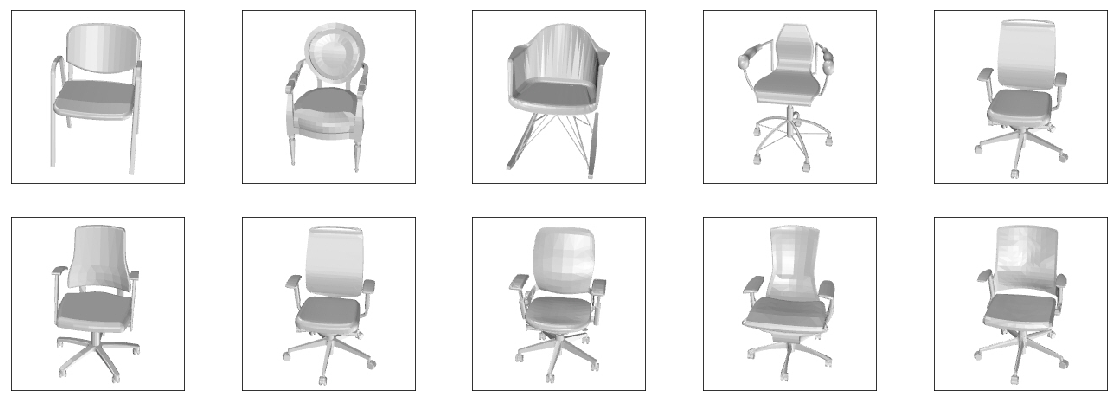

In [101]:
fig1=plt.figure(figsize=(20, 7))
columns = 5
rows = 2

for i in range(1, columns*rows+1):
    img = cv2.imread('data/_train' + '/'+ labels[sorted_matches][190:][i-1] + '/' + labels[sorted_matches][190:][i-1] 
                     + '_view24.jpg')
    fig1.add_subplot(rows, columns, i)
    plt.tick_params(
    bottom='off',      
    top='off',
    left='off',
    labelleft = 'off',
    labelbottom = 'off')   
    plt.imshow(img)
plt.show()

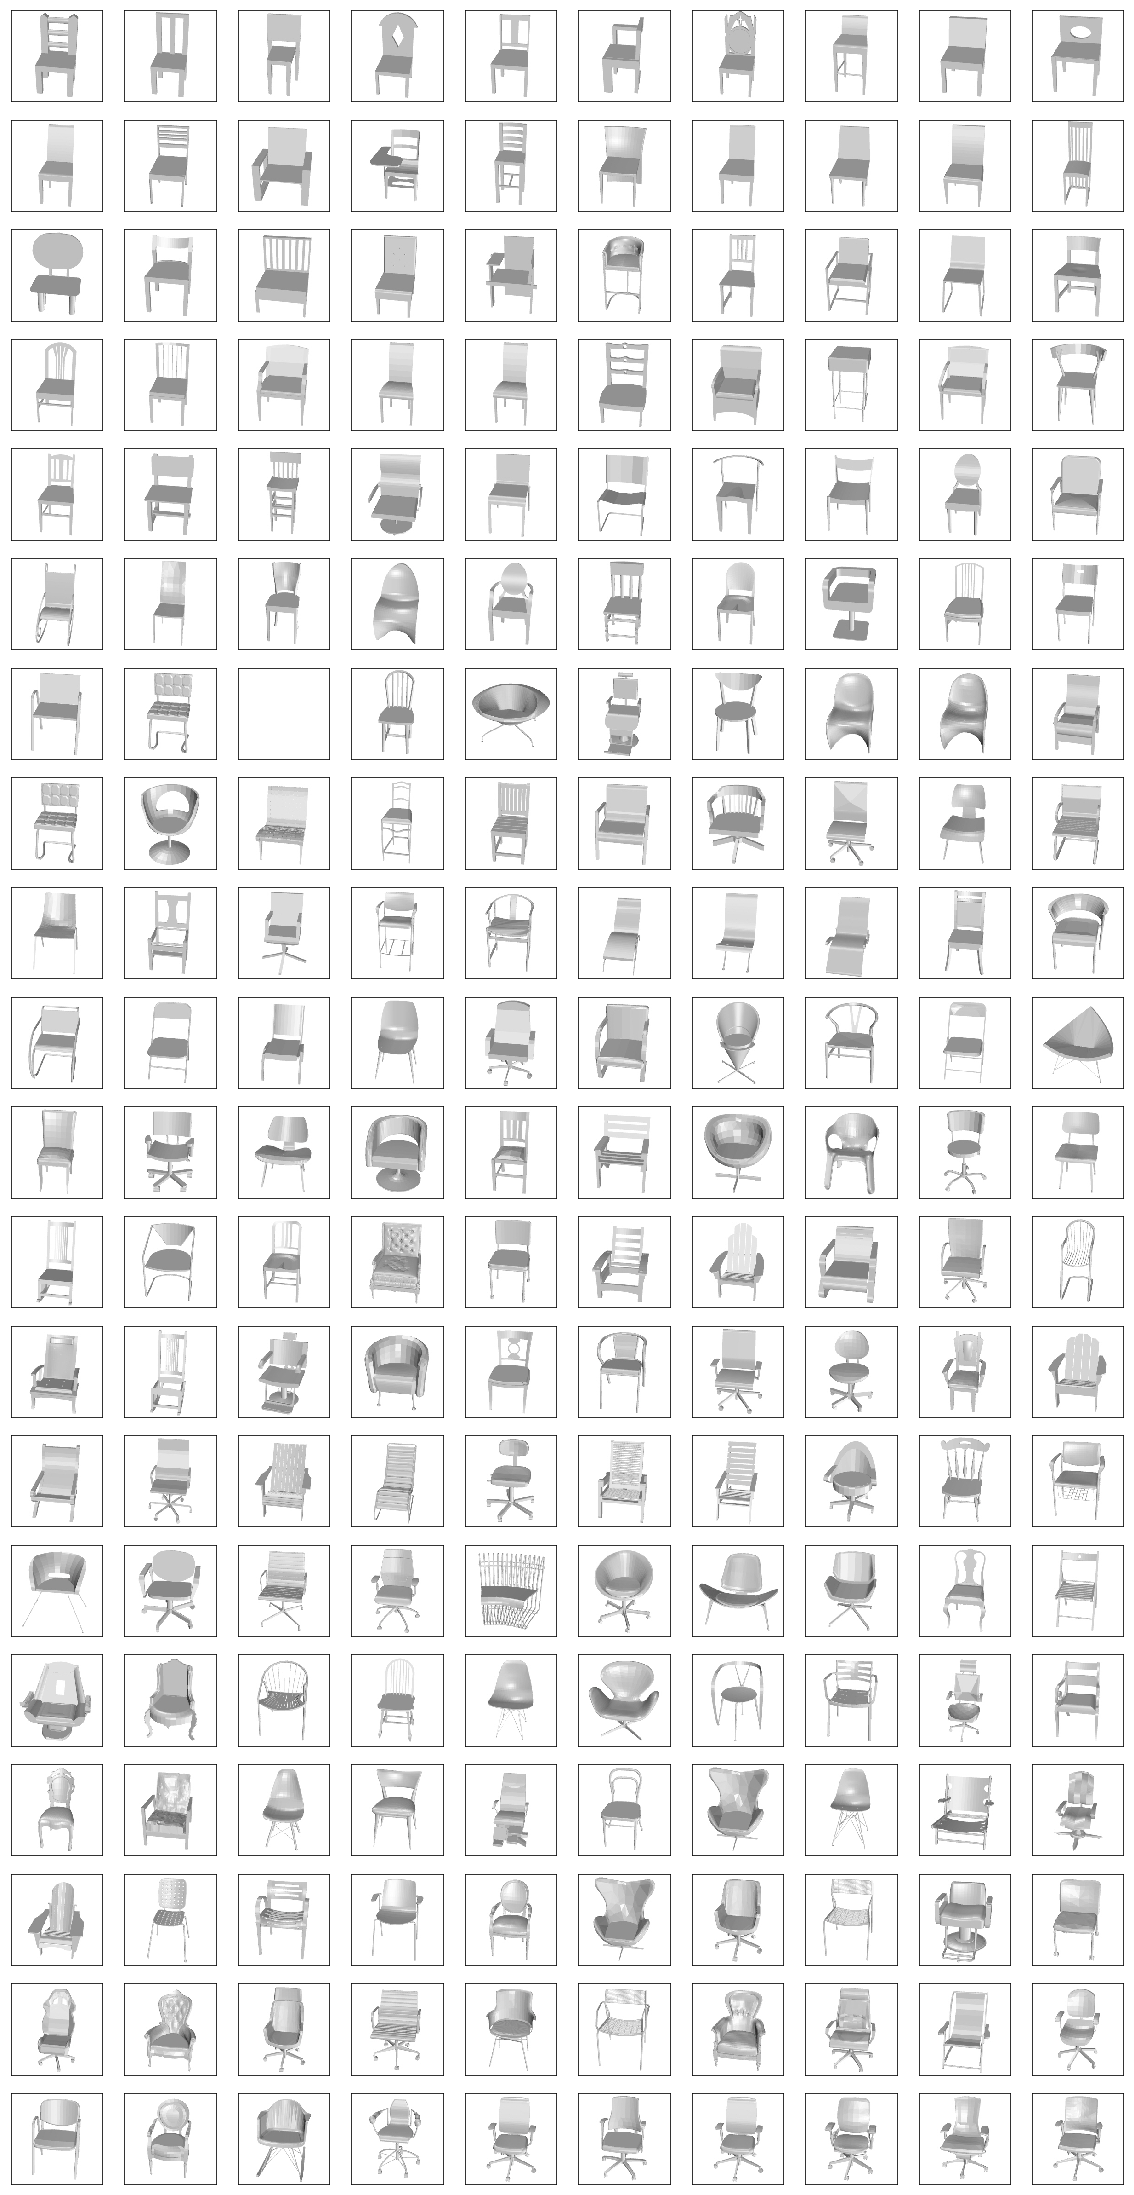

In [100]:
fig1=plt.figure(figsize=(20, 40))
columns = 10
rows = 20

for i in range(1, columns*rows+1):
    img = cv2.imread('data/_train' + '/'+ labels[sorted_matches][i-1] + '/' + labels[sorted_matches][i-1] 
                     + '_view24.jpg')
    fig1.add_subplot(rows, columns, i)
    plt.tick_params(
    bottom='off',      
    top='off',
    left='off',
    labelleft = 'off',
    labelbottom = 'off')      

    plt.imshow(img)
    
plt.show()